In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from random import shuffle
import math
import random
import matplotlib.pyplot as plt
import torch
import math
import datetime
import pickle

In [2]:


class Connect2Model(nn.Module):

    def __init__(self, board_size, action_size, device):

        super(Connect2Model, self).__init__()

        self.device = device
        self.size = board_size
        self.action_size = action_size

        self.fc1 = nn.Linear(in_features=self.size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)

        # Two heads on our network
        self.action_head = nn.Linear(in_features=64, out_features=self.action_size)
        self.value_head = nn.Linear(in_features=64, out_features=1)

        self.to(device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        action_logits = self.action_head(x)
        value_logit = self.value_head(x)

        return F.softmax(action_logits, dim=1), value_logit

    def predict(self, board):
        board = torch.FloatTensor(board.astype(np.float32)).to(self.device)
        board = board.view(1, self.size)
        self.eval()
        with torch.no_grad():
            pi, v = self.forward(board)

        return pi.data.cpu().numpy()[0], v.data.cpu().numpy()[0]

In [ ]:
import os
import numpy as np
from random import shuffle

import torch
import torch.optim as optim

class Trainer:

    def __init__(self, dl_model , model, args, eps):
        self.dl_model = dl_model
        self.model = model
        self.args = args
        self.mcts = MCTS_DL(self.dl_model, self.model, self.args)
        self.episode_scores = eps

    def execute_episode(self, tmp, plotting, random, greedy):

        train_examples = []
        state = []

        while True:

            self.mcts = MCTS_DL(self.dl_model, self.model, self.args) 
            root = self.mcts.run(state)

            action_probs = [0 for _ in range(self.model.n_songs)]
            for k, v in root.children.items():
                action_probs[k] = v.visit_count

            action_probs = action_probs / np.sum(action_probs)
            train_examples.append((state, action_probs))

            action = root.select_action(temperature=tmp) # This is where we actually use temperature to adjust probability distribution across the action space. 
            state = self.model.get_next_state(state, action)
            reward = self.model.get_reward(state)


            if reward is not None:
                ret = []
                for hist_state, hist_action_probs in train_examples:
                    # [Board, actionProbabilities, Reward]
                    ret.append((self.model.state_to_input(hist_state), hist_action_probs, reward))
                print(hist_state, reward)
                if plotting:
                  self.episode_scores.append(reward)
                  plt.plot(self.episode_scores)
                  plt.axhline(y=random, color='b', linestyle='-')
                  plt.axhline(y=greedy, color='g', linestyle='-')

                  plt.show()

                return ret

    def learn(self, temperature, random, greedy):
        for i in range(1, self.args['numIters'] + 1):

            print("{}/{}".format(i, self.args['numIters']))

            train_examples = []

            for eps in range(self.args['numEps']):
                iteration_train_examples = self.execute_episode(temperature, False, random, greedy)
                train_examples.extend(iteration_train_examples)

            self.execute_episode(0, True, random, greedy)
            shuffle(train_examples)
            self.train(train_examples)
            filename = self.args['checkpoint_path']
            self.save_checkpoint(folder=".", filename=filename+'temperature: {}, numIters: {}, numEps: {}, numSims: {}'.format(temperature, self.args['numEps'], self.args['numIters'], self.args['num_simulations']))

    def train(self, examples):
        optimizer = optim.Adam(self.dl_model.parameters(), lr=5e-4)
        pi_losses = []
        v_losses = []

        for epoch in range(self.args['epochs']):
          self.dl_model.train()

          batch_idx = 0

          while batch_idx < int(len(examples) / self.args['batch_size']):
            sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
            boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
            boards = torch.FloatTensor(np.array(boards).astype(np.float64))
            target_pis = torch.FloatTensor(np.array(pis))
            target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

            # predict
            boards = boards.contiguous().cuda()
            target_pis = target_pis.contiguous().cuda()
            target_vs = target_vs.contiguous().cuda()

            # compute output
            out_pi, out_v = self.dl_model(boards)
            l_pi = self.loss_pi(target_pis, out_pi)
            l_v = self.loss_v(target_vs, out_v)
            total_loss = l_pi + l_v # Does it make sense to have a total loss? Do you normalize the losses? 

            pi_losses.append(float(l_pi))
            v_losses.append(float(l_v))

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            batch_idx += 1
    

          print()
          print("Policy Loss", np.mean(pi_losses))
          print("Value Loss", np.mean(v_losses))
          # print("Examples:")
          # print(out_pi[0].detach())
          # print(target_pis[0])
          

    def loss_pi(self, targets, outputs):
        loss = -(targets * torch.log(outputs)).sum(dim=1)
        return loss.mean()

    def loss_v(self, targets, outputs):
        loss = torch.sum((targets-outputs.view(-1))**2)/targets.size()[0]
        return loss

    def save_checkpoint(self, folder, filename):
        if not os.path.exists(folder):
            os.mkdir(folder)

        filepath = os.path.join(folder, filename)
        torch.save({
            'state_dict': self.dl_model.state_dict(),
        }, filepath)


In [ ]:
import pandas as pd
import os
import numpy as np
import itertools
import scipy.spatial.distance as distlib
import scipy.stats
import random as rand
import time

class RecommendationSystem:
    def __init__(self, dataset_with_bins, n_features, n_bins):
        '''
        We assume here that the columns of the dataset here are already the binary percentile bins for all features 
        For sanity check: n_features x n_bins = length(dataset_with_bins)
        '''
        self.data = dataset_with_bins # assuming this is the whole dataset split that we want to work with
        self.data.index = np.arange(np.shape(self.data)[0])
        self.n_features = n_features
        self.n_bins = n_bins
        self.k_s = 10 # user picks 10 songs that they enjoy the most
        self.k_t = 10 # for now, just queue the user 10 songs to generate the transition preference model from -- has to be higher than |Action Space| // 2
        self.var_param = 100 # parameter that determines the "variance" of the user reference distribution that the user song picks are generated from
        self.initial_songs = self.gen_user_song_picks() # assuming this is still a pandas df of k_s rows, but only containing the song rows that the user prefers
        
        # Initialize preferences
        self.init_song_preferences()
        self.init_transition_preferences()
        

    def init_song_preferences(self):
        # Initialize preference array
        self.phi_s = (1/((self.k_s + 1) * self.n_bins)) * np.ones((self.n_features * self.n_bins, 1))
        tmp = (np.sum(self.initial_songs.values, axis = 0)) * (1/(self.k_s + 1))
        self.phi_s = self.phi_s + np.reshape(tmp, (len(tmp), 1))

    def theta_t(self, idx_a, idx_b):
        '''
        Input: indices of songs a and b within the provided dataset (int)

        Output: vector theta_t, assuming the feature sequence of 1-i, 1-2, ..., 1-n_bins, 2-1, ..., n_bins-1, n_bins-2, ..., n_bins-n_bins
        '''
        indices = np.array([], dtype=int)
        for i in range(self.n_features):
            a_bin_idx = np.where(self.data.loc[idx_a][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            b_bin_idx = np.where(self.data.loc[idx_b][self.data.columns[i*self.n_bins:(i+1)*self.n_bins]] == 1.0)[0]
            indices = np.append(indices, int(i*(self.n_bins*self.n_bins) + a_bin_idx*self.n_bins + b_bin_idx))
        out = np.zeros((self.n_bins * self.n_bins * self.n_features, 1))
        out[indices] = 1
        return out

    def init_transition_preferences(self):
        # Initialize user preference vector

        # Take the upper-median preference split
        self.Rs = np.sum(np.matmul(self.data.values, self.phi_s), axis=1)
        self.Mstar = self.data.copy()
        self.Mstar['Rs'] = self.Rs
        self.Mstar.sort_values('Rs', inplace = True, ascending = False)
        self.Mstar = self.Mstar[:np.shape(self.Mstar)[0] // 2]
        self.Mstar['old_index'] = self.Mstar.index
        self.Mstar.index = np.arange(np.shape(self.Mstar)[0])

        # Generate 10th percentile distance of all pairwise distances from M (not M*)
        self.diff = distlib.pdist(self.data.values, 'cosine') #taking cosine distance metric between songs
        self.delta = np.percentile(self.diff, 10, axis=0)
        self.distances = distlib.squareform(self.diff)
        np.fill_diagonal(self.distances, np.inf)

        # Generate a representative subset of M*
        self.representatives = self.delta_medoids(self.Mstar, self.delta)
        if self.k_t > len(self.representatives):
            print("[WARNING] k_t parameter too large for generated representative subset. Consider using a larger dataset or reducing k_t value")
            print("Setting k_t =", len(self.representatives), "to match the generated number of representatives through delta-medoids")
            self.k_t = len(self.representatives)
        else:
            print("k_t = {} <= representatives = {} --> OK".format(self.k_t, len(self.representatives)))
        song_prev = np.random.choice(self.representatives)
        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == song_prev))
        #TODO: constraint k_t between length of representatives, give warning message

        self.phi_t = (1/(self.k_t * self.n_bins*self.n_bins)) * np.ones((self.n_features * self.n_bins * self.n_bins, 1))
        
        for i in range(self.k_t-1):
            next_song, theta = self.pick_next_song(song_prev, self.user_ref_samples_t[:, i])
            self.phi_t += (1/(self.k_t)) * theta
            song_prev = next_song

    def pick_next_song(self, previous_song, reference):
        min_dist = 1e06
        for song in self.representatives:
            theta_current = self.theta_t(previous_song, song)
            dist = distlib.cosine(theta_current, reference)
            if dist < min_dist:
                min_theta = theta_current
                min_song = song
                min_dist = dist

        self.representatives = np.delete(self.representatives, np.argwhere(self.representatives == min_song))
        return min_song, min_theta

    def one_shot_delta(self, data, delta, clusters):
        # Remember to change the distance metric in case we change delta distance definition
        distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        distances = distlib.squareform(distances)
        np.fill_diagonal(distances, np.inf) # Need to populate the diagonals with inf since we look for the smallest off-diagonal value afterwards
        for index, row in data.iterrows():
            dist = 1e6
            representatives = np.array(list(clusters.keys()))
            representatives.dtype = 'int64'

            if len(representatives) > 0:
              # rep = np.where(distances[:, index] == np.min(distances[:, index][representatives]))[0]
              rep = np.intersect1d(np.where(distances[:, index] == np.min(distances[:, index][representatives]))[0], representatives) # Take the intersection to make sure we select the correct index belonging to the set of representatives
              if len(rep) > 1:
                  rep = rep[0]
              else:
                  rep = int(rep)
              dist = distances[rep, index]

            if dist <= delta:
                clusters[rep] = np.append(clusters[rep], index)
            else: 
                rep = index
                clusters[rep] = np.array([rep])

        out = clusters.keys()
        return clusters

    def delta_medoids(self, data, delta):
        distances = distlib.pdist(data[data.columns[:-2]], 'cosine')
        distances = distlib.squareform(distances)
        np.fill_diagonal(distances, 0)
        exit_loop = False
        i = 0
        clusters = {}
        while not exit_loop:
            i +=1
            clusters = self.one_shot_delta(data, delta, clusters)
            if 1 != i:
                representatives_prev = representatives
            else:
                representatives_prev = np.array([], dtype = 'int32')
            representatives = np.array([], dtype = 'int32')
            for cluster in clusters.items():
                cluster = cluster[1]
                cluster_dists = distlib.pdist(data.loc[cluster], 'cosine')
                cluster_dists = distlib.squareform(cluster_dists)
                argmin = np.argmin(np.sum(cluster_dists, axis=0))
                representatives = np.append(representatives, cluster[argmin])
            if np.array_equal(np.sort(representatives), np.sort(representatives_prev)):
                exit_loop = True
        # Convert back to indices of the original data array
        representatives = data['old_index'][np.in1d(data.index, representatives)].values
        return representatives

    def gen_user_song_picks(self):
        """
        Returns a subset of the dataframe of k_s songs closest to the random samples generated from the user preference distribution, simulating picked user reference
        The user reference distribution is generated here and can be accessed through self.user_ref
        """
        self.user_ref_s, self.user_ref_samples_s, self.user_ref_t, self.user_ref_samples_t  = self.gen_user_ref()
        sample_index = np.arange(np.shape(self.data)[0], np.shape(self.data)[0] + self.k_s, dtype='int32')
        to_append = pd.DataFrame(np.transpose(self.user_ref_samples_s), index = sample_index)
        sample = self.data.copy().append(to_append)
        dists_with_samples = distlib.pdist(sample, metric='cosine')
        dists_with_samples = distlib.squareform(dists_with_samples)
        np.fill_diagonal(dists_with_samples, np.inf)
        user_selected_songs = np.array([], dtype='int32')

        for i in sample_index:
            min_ind = np.argmin(dists_with_samples[:sample_index[0], i])
            user_selected_songs = np.append(user_selected_songs, min_ind)
            dists_with_samples[min_ind, :] = np.inf #Do not allow to pick this row anymore
        return self.data.loc[user_selected_songs]
        

    def gen_user_ref(self):
        '''
        Generates a random "ground-truth" user song and transitions preference distributions over features (kind of
        like a ground-truth phi_s and phi_t), as well as k_s for songs (and k_t, for transitions, respectively) samples from it, that are later used to 
        simulate user song preferences and transition preferences that the user preference vectors phi_s and phi_t are learned from

        Input: var_param: a parameter that alters the variance of the distribution over each feature of the ground truth user preference vectors, int

        Output: - user_reference_s (numpy array, n_bins x n_features, 1): ground-truth user song preference distribution over each feature
                - user_samples_s (numpy array, n_bins x n_features, k_s): k_s samples of the "ground truth phi_s", used to select initial, user-preferred songs
                - user_reference_t (numpy array, n_bins*n_bins x n_features, 1): ground-truth user transition preference distribution over each feature
                - user_samples_t (numpy array, n_bins*n_bins x n_features, k_t): k_s samples of the "ground truth phi_t", used to select songs that the user preference phi_t will be estimated from 
        '''
    
        user_reference_s = np.array([])
        user_reference_t = np.array([])

        user_samples_s = np.zeros((self.n_features * self.n_bins, self.k_s))
        user_samples_t = np.zeros((self.n_features * self.n_bins * self.n_bins, self.k_t))

        for i in range(self.n_features):
            vec_s = np.random.randint(1, self.var_param, (self.n_bins, ))
            vec_s = vec_s/np.sum(vec_s)
            user_reference_s = np.append(user_reference_s, vec_s)
            sample_bins_s = np.array(rand.choices(np.arange(self.n_bins, dtype='int32'), vec_s, k = self.k_s))
            user_samples_s[i*self.n_bins + sample_bins_s, np.arange(self.k_s, dtype='int32')] = 1
            
            vec_t = np.random.randint(1, self.var_param, (self.n_bins * self.n_bins, ))
            vec_t = vec_t/np.sum(vec_t)
            user_reference_t = np.append(user_reference_t, vec_t)
            sample_bins_t = np.array(rand.choices(np.arange(self.n_bins * self.n_bins, dtype='int32'), vec_t, k = self.k_t))
            user_samples_t[i*self.n_bins*self.n_bins + sample_bins_t, np.arange(self.k_t, dtype='int32')] = 1

        return user_reference_s, user_samples_s, user_reference_t, user_samples_t


In [11]:
def ucb_score(parent, child):
    """
    The score for an action that would transition between the parent and child.
    """
    if child.prior < 0.0001:
      return -100000000
    prior_score = child.prior * math.sqrt(parent.visit_count) / (child.visit_count + 1)
    if child.visit_count > 0:
        # The value of the child is from the perspective of the opposing player
        value_score = child.value()
    else:
        value_score = 100000

    return value_score + prior_score

In [12]:
class MDP:
    def __init__(self, file_name, playlist_length):

        df = pd.read_csv(file_name, index_col=None)

        self.features = ['duration', 'key_confidence', 'end_of_fade_in', 'mode_confidence', 'start_of_fade_out', 'tempo',
                    'artist_hotttnesss', 'song_hotttnesss']
        
        self.filtered_df = df[self.features].loc[~(df[self.features]==0).any(axis=1)]
        self.filtered_df.dropna(inplace=True)
        self.filtered_df = self.filtered_df.head(20) # Here we selected a subset of the whole dataset due to performance issues
        self.filtered_df = self.filtered_df.reset_index(drop=True)

        self.n_rows = len(self.filtered_df.index)
        self.n_songs = self.n_rows
        self.n_bins = 10
        self.n_features = len(self.features)
        self.playlist_length = playlist_length


        self.id_song_to_vec = dict(zip(self.filtered_df.index, [np.zeros(self.n_bins*self.n_features) for _ in self.filtered_df.index]))
        self.song_priors = np.ones(self.n_songs)
        self.songs_list = self.filtered_df.index
        self.songs = self.songs_list

        for f in range(self.n_features):

            feature = self.features[f]
            sorted_df = self.filtered_df.sort_values(by=[feature])
            i = 0
            for idx, row in sorted_df.iterrows():
                bin = i * self.n_bins // self.n_rows
                self.id_song_to_vec[idx][f * 10 + bin] = 1
                i += 1


        df_input = pd.DataFrame.from_dict(self.id_song_to_vec, orient='index')
        rs = RecommendationSystem(df_input, self.n_features, self.n_bins)
        self.phi_s = rs.phi_s.reshape(80)
        self.phi_t = rs.phi_t.reshape(800)
        self.transition_reward = np.zeros((self.n_songs, self.n_songs))
        self.song_reward = np.zeros(self.n_songs)
        for i in range(self.n_songs):
          self.song_reward[i] = np.dot(self.phi_s, self.theta_s(i))
          for j in range(self.n_songs):
            self.transition_reward[i,j] = np.dot(self.phi_t, self.get_theta_t(i, j))


    def get_next_state(self, state, action):
      return state + [action]
      
    def get_valid_actions(self, state):
        # All actions are invalid by default
        valid_actions = [0] * self.n_songs

        for song in range(self.n_songs):
            if song not in state:
                valid_actions[song] = 1

        return valid_actions

    def state_to_input(self, state):
      input = np.ones(self.playlist_length*self.n_features*10)*-1 # Where is the minus sign coming from?
      for i in range(len(state)):
        song = state[i]
        input[i*self.n_features*10:(i+1)*self.n_features*10] = self.id_song_to_vec[song]
      return input

    def get_reward(self, final_state):
      if len(final_state) < self.playlist_length:
        return None
      elif len(final_state) == self.playlist_length:
        state = []
        trajectory_states = [state]
        trajectory_actions = []
        for song in final_state:
          state = self.get_next_state(state, song)
          trajectory_states.append(state)
          trajectory_actions.append(song)
          
        return self.payoff_trajectory(trajectory_states, trajectory_actions)
      else:
        print("Error: length > self.playlist_length")
        return None


    def get_theta_t(self, s1, s2):
        theta_t = np.zeros(800)
        for f in range(len(self.features)):
            for i in range(10):
                for j in range(10):
                    if self.id_song_to_vec[s1][f*10 + i] == 1 and  self.id_song_to_vec[s2][f*10 + j]:
                        theta_t[f*100 + i*10 + j] = 1
        return  theta_t

    def theta_s(self, s):
        return self.id_song_to_vec[s]

    def R(self, s, a):
        Rs = self.song_reward[a]
        Rt = 0
        for i in range(len(s)):
            song_past = s[len(s)-i-1]
            Rt += 1/((i+1)**(0.1)) * self.transition_reward[song_past,a]
        return Rs + Rt


    def payoff_trajectory(self, trajectory_states, trajectory_actions):
      payoff = 0

      for t in range(len(trajectory_actions)):
        payoff +=  self.R(trajectory_states[t], trajectory_actions[t])
      return payoff

    def MC_value(self, s):
      count = 0
      sum_values = 0
      state = s
      # Past episodes
      episode_states = [[]]
      episode_actions = []

      for i in range(model.playlist_length):
        if i < len(s):
          state = s[:i+1]
          action = s[i]
        else:
          action_probs = list(model.song_priors)
          for song_id in range(model.n_songs):
            if song_id in state:
              action_probs[song_id] = 0

          action_probs = np.array(action_probs)/np.sum(np.array(action_probs))
          action = np.random.choice(model.songs_list, 1, p=action_probs)[0]
          state = episode_states[-1] + [action]
        episode_states.append(state)
        episode_actions.append(action)

      # print("MC estimate:", s, episode_states, episode_actions)
          
      # Set MC 
      payoff = self.payoff_trajectory(episode_states, episode_actions)
      
      return payoff

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.ucb_scores = np.array([]) # Here we would keep the UCB scores of the children
        self.state = None

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_action(self, temperature):
        """
        Select action according to the visit count distribution and the temperature.
        """
        visit_counts = np.array([child.visit_count for child in self.children.values()])
        actions = [action for action in self.children.keys()]
        if temperature == 0:
            action = actions[np.argmax(visit_counts)]
        elif temperature == float("inf"):
            action = np.random.choice(actions)
        else:
            # See paper appendix Data Generation
            visit_count_distribution = visit_counts ** (1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            action = np.random.choice(actions, p=visit_count_distribution)

        return action

    def select_child(self):
        """
        Select the child with the highest UCB score.
        """
        best_score = -np.inf
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = ucb_score(self, child)
            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def expand(self, state, action_probs):
        """ 
        We expand a node and keep track of the prior policy probability given by neural network
        """
        self.state = state
        for song_id in range(len(action_probs)):
            self.children[song_id] = Node(action_probs[song_id])
              

    def __repr__(self):
        """
        Debugger pretty print node info
        """
        prior = "{0:.2f}".format(self.prior)
        return "{} Prior: {} Count: {} Value: {}".format(self.state.__str__(), prior, self.visit_count, self.value())


In [13]:
import torch
import math
import numpy as np

class MCTS_DL:

    def __init__(self, dl_model, model, args):
        self.dl_model = dl_model
        self.model = model
        self.args = args

    def run(self, state):
        root = Node(0)

        # EXPAND root
        action_probs, value = self.dl_model.predict(self.model.state_to_input(state))
        valid_actions = self.model.get_valid_actions(state)
        action_probs = action_probs * valid_actions  # mask invalid moves
        action_probs /= np.sum(action_probs)
        root.expand(state, action_probs)

        for _ in range(self.args['num_simulations']):
            node = root
            search_path = [node]

            # SELECT
            while node.expanded():
                action, node = node.select_child()
                search_path.append(node)

            parent = search_path[-2]
            state = parent.state
            # Now we're at a leaf node and we would like to expand
            # Players always play from their own perspective
            next_state = self.model.get_next_state(state, action)
            # Get the board from the perspective of the other player

            # The value of the new state from the perspective of the other player
            value = self.model.get_reward(next_state)
            if value is None:
                # If the game has not ended:
                # EXPAND
                action_probs, value = self.dl_model.predict(self.model.state_to_input(next_state))
                valid_actions = self.model.get_valid_actions(next_state)
                action_probs = action_probs * valid_actions  # mask invalid moves
                action_probs /= np.sum(action_probs)
                node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value 
            node.visit_count += 1

In [14]:
class MCTS:

    def __init__(self, model, args):
        self.model = model
        self.args = args

    def run(self, root_state):
        print("")
        root = Node(0)
        # EXPAND root
        action_probs = list(self.model.song_priors)
        for song_id in range(self.model.n_songs):
          if song_id in root_state:
            action_probs[song_id] = 0
        action_probs /= np.sum(action_probs)
        root.expand(root_state, action_probs)

        for _ in range(self.args['num_simulations']):

            node = root
            search_path = [node]

            # SELECT
            while node.expanded():              
                action, node = node.select_child()
                search_path.append(node)
            parent = search_path[-2]
            state = parent.state
            # # Now we're at a leaf node and we would like to expand
            # # Players always play from their own perspective
            # next_state, _ = self.game.get_next_state(state, action=action)
            # # Get the board from the perspective of the other player
            # next_state = self.game.get_canonical_board(next_state, )

            # The value of the new state from the perspective of the other player
            # value = self.game.get_reward_for_player(next_state)
            next_state = parent.state + [action]
            
            value = model.MC_value(next_state)
           
            action_probs = list(self.model.song_priors)
            for song_id in range(self.model.n_songs):
              if song_id in parent.state or song_id == action:
                action_probs[song_id] = 0

            node.expand(next_state, action_probs)
        

            # if value is None:
                # If the game has not ended:
                # EXPAND
                # action_probs, value = model.predict(next_state)
                # valid_moves = self.game.get_valid_moves(next_state)
                # action_probs = action_probs * valid_moves  # mask invalid moves
                # action_probs /= np.sum(action_probs)
                # node.expand(next_state, action_probs)

            self.backpropagate(search_path, value)

        return root

    def backpropagate(self, search_path, value):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value
            node.visit_count += 1


In [15]:
def get_random_trajectory(model):
  songs = set(model.songs)
  state = []
  trajectory_states = [state]
  trajectory_actions = []
  for i in range(playlist_length):
    action = random.sample(songs, 1)[0]
    state = model.get_next_state(state, action)
    trajectory_states.append(state)
    trajectory_actions.append(action)
    songs.remove(action)
  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

def get_greedy_trajectory(model):
  songs = set(model.songs)
  state = []
  trajectory_states = [state]
  trajectory_actions = []
  for i in range(playlist_length):
    max_score = -np.inf
    max_action = -1
    for try_action in songs:
      try_state = model.get_next_state(state, try_action)
      try_trajectory_states = list(trajectory_states)
      try_trajectory_actions = list(trajectory_actions)
      try_trajectory_states.append(try_state)
      try_trajectory_actions.append(try_action)
      score = model.payoff_trajectory(try_trajectory_states, try_trajectory_actions)
      if score > max_score:
        max_action = try_action
        max_score = score
    
    action = max_action
    state = model.get_next_state(state, action)
    trajectory_states.append(state)
    trajectory_actions.append(action)
    songs.remove(action)
  cum_rewards = model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

def get_MCTS_trajectory(model):
  # MCTS
  mcts = MCTS(model, args)
  trajectory_states = [[]]
  trajectory_actions = []
  state = []
  for i in range(playlist_length):
    root = mcts.run(state)
    counts = [node.visit_count for node in root.children.values()]
    max_val = max(counts)
    song = counts.index(max_val)
    state = list(root.children.values())[song].state
    trajectory_states.append(state)
    trajectory_actions.append(song)
    # print(counts, max_index, state)
    for action, child in root.children.items():
      score = ucb_score(root, child)
      # print(child.state, score)
  cum_rewards =  model.payoff_trajectory(trajectory_states, trajectory_actions)
  return cum_rewards

[WARNING] k_t parameter too large for generated representative subset. Consider using a larger dataset or reducing k_t value
Setting k_t = 4 to match the generated number of representatives through delta-medoids
20
1/100
[3, 12, 10, 9, 6, 16, 2, 14, 0] 9.984016933034905
[3, 12, 10, 9, 6, 16, 2, 14, 0] 9.984016933034905
[3, 12, 2, 9, 6, 16, 13, 14, 0] 10.624530899687933
[3, 12, 10, 9, 6, 16, 2, 14, 0] 9.984016933034905
[3, 12, 2, 9, 6, 16, 10, 14, 0] 9.732561883688772
[3, 12, 10, 9, 0, 16, 2, 14, 4] 12.551313099744538
[3, 12, 10, 9, 6, 16, 2, 14, 0] 9.984016933034905
[3, 12, 2, 9, 6, 16, 7, 14, 0] 11.060728828944978
[3, 12, 10, 9, 6, 16, 2, 14, 0] 9.984016933034905
[3, 12, 10, 14, 0, 16, 2, 17, 19] 10.03776100457419
[3, 12, 2, 9, 6, 16, 5, 14, 0] 12.319933348824843


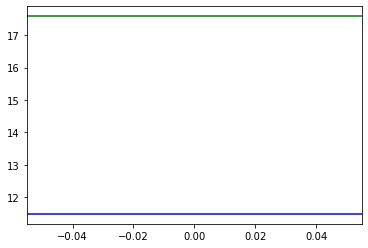


Policy Loss 3.0237370332082114
Value Loss 97.19658533732097

Policy Loss 3.0960733294487
Value Loss 82.13994566599528
2/100
[3, 12, 6, 9, 14, 16, 1, 11, 5] 12.341667776059793
[3, 12, 6, 9, 14, 1, 7, 11, 5] 12.136201739496359
[3, 12, 6, 9, 11, 14, 1, 16, 5] 12.34613374878997
[3, 12, 6, 9, 14, 5, 7, 1, 11] 12.593819361857012
[3, 12, 6, 9, 14, 1, 16, 11, 5] 12.341667776059795
[3, 12, 6, 9, 14, 1, 7, 11, 5] 12.136201739496359
[3, 12, 6, 9, 14, 1, 5, 11, 19] 11.660777941198768
[3, 12, 6, 9, 14, 1, 5, 11, 19] 11.660777941198768
[3, 12, 6, 9, 14, 1, 13, 11, 5] 11.814736809002005
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 1, 5, 11, 19] 11.660777941198768


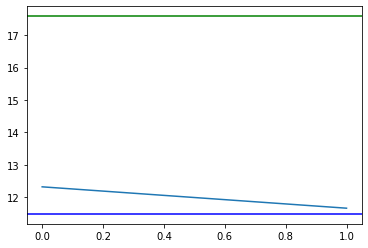


Policy Loss 3.259406050046285
Value Loss 57.589064280192055

Policy Loss 3.383406082789103
Value Loss 40.49660428365072
3/100
[3, 12, 6, 9, 14, 1, 11, 5, 19] 11.751668756706657
[3, 12, 6, 9, 14, 1, 4, 11, 5] 13.522905253864376
[3, 12, 6, 9, 14, 1, 4, 11, 5] 13.522905253864376
[3, 12, 6, 9, 14, 1, 13, 11, 5] 11.814736809002005
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 1, 4, 11, 5] 13.522905253864376
[3, 12, 6, 9, 14, 1, 13, 11, 5] 11.814736809002005
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 1, 19, 7, 14, 5] 12.524901330634247
[3, 12, 6, 9, 14, 1, 5, 11, 19] 11.660777941198768
[3, 12, 6, 9, 14, 1, 0, 11, 5] 12.124030135235763


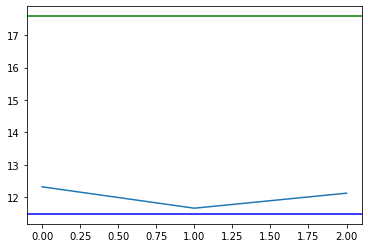


Policy Loss 3.5060157775878906
Value Loss 13.31422233581543

Policy Loss 3.375792702039083
Value Loss 12.778129736582438
4/100
[3, 12, 6, 9, 14, 1, 0, 11, 5] 12.124030135235763
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 16, 11, 5, 19] 12.102386921581788
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 1, 11, 5, 19] 11.751668756706657
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 1, 16, 11, 5] 12.341667776059795
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 11, 1, 5, 19, 13] 11.594434072297993
[3, 12, 6, 9, 14, 1, 0, 11, 5] 12.124030135235763


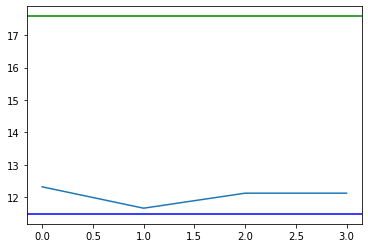


Policy Loss 3.114492972691854
Value Loss 6.033064206441243

Policy Loss 3.0473981897036233
Value Loss 4.112275063991547
5/100
[3, 12, 6, 9, 14, 1, 7, 11, 5] 12.136201739496359
[3, 12, 6, 9, 14, 1, 7, 11, 5] 12.136201739496359
[3, 12, 6, 9, 14, 1, 17, 11, 5] 11.263676883911936
[3, 12, 6, 9, 14, 16, 17, 11, 5] 11.614395048787067
[3, 12, 6, 9, 14, 1, 0, 11, 5] 12.124030135235763
[3, 12, 6, 9, 14, 1, 15, 11, 5] 13.004850216253102
[3, 12, 6, 9, 14, 1, 13, 11, 5] 11.814736809002005
[3, 12, 6, 9, 14, 1, 16, 11, 5] 12.341667776059795
[3, 12, 6, 9, 14, 1, 19, 11, 5] 11.620747022923226
[3, 12, 6, 9, 14, 1, 2, 11, 5] 11.487666498872127
[3, 12, 6, 9, 14, 1, 0, 11, 5] 12.124030135235763


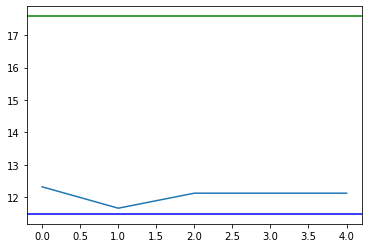


Policy Loss 2.8152765035629272
Value Loss 1.5453050136566162

Policy Loss 2.7058504223823547
Value Loss 1.4033248623212178
6/100
[3, 12, 6, 9, 14, 1, 15, 11, 5] 13.004850216253102
[3, 12, 6, 9, 14, 1, 11, 5, 15] 15.196191544455777
[3, 12, 6, 9, 14, 1, 0, 11, 15] 13.378009726273959
[3, 12, 6, 9, 14, 1, 13, 5, 15] 15.525964262884592
[3, 12, 6, 9, 14, 1, 17, 5, 15] 14.741646089910324
[3, 12, 6, 9, 14, 1, 4, 11, 5] 13.522905253864376
[3, 12, 6, 9, 14, 1, 4, 11, 5] 13.522905253864376
[3, 12, 6, 9, 14, 1, 13, 5, 15] 15.525964262884592
[3, 12, 6, 9, 14, 1, 17, 5, 15] 14.741646089910324
[3, 12, 6, 9, 14, 1, 4, 11, 5] 13.522905253864376
[3, 12, 6, 9, 14, 1, 0, 11, 15] 13.378009726273959


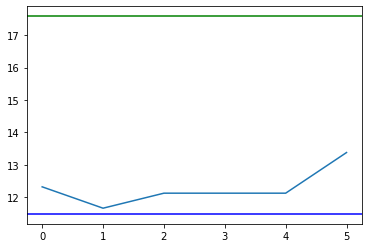


Policy Loss 2.8876708348592124
Value Loss 2.5397994915644326

Policy Loss 2.840400755405426
Value Loss 2.6165030002593994
7/100
[3, 12, 6, 9, 14, 1, 15, 11, 4] 15.478908451083585
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 15, 11, 4] 15.478908451083585
[3, 12, 6, 9, 14, 1, 0, 5, 15] 15.611267974158162
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 17, 5, 15] 14.741646089910324
[3, 12, 6, 9, 14, 1, 5, 11, 15] 15.052988894605381
[3, 12, 6, 9, 14, 1, 11, 5, 15] 15.196191544455777
[3, 12, 6, 9, 14, 1, 16, 5, 15] 15.828905614982192
[3, 12, 6, 9, 14, 1, 0, 5, 15] 15.611267974158162


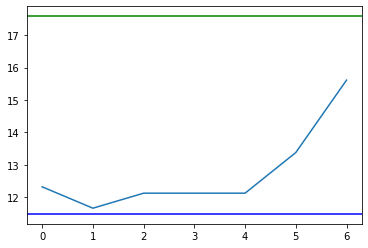


Policy Loss 2.833213766415914
Value Loss 3.2998674313227334

Policy Loss 2.755055546760559
Value Loss 2.283890575170517
8/100
[3, 12, 6, 9, 14, 1, 7, 15, 4] 14.661682696699465
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 7, 15, 4] 14.661682696699465
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824


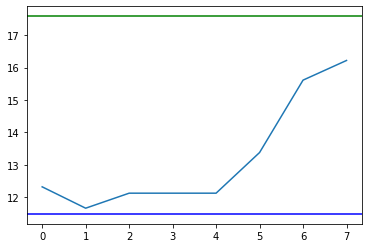


Policy Loss 2.7792020241419473
Value Loss 1.7408448209365208

Policy Loss 2.773673872152964
Value Loss 1.463686707119147
9/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 2, 11, 4] 12.661580125777053
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824


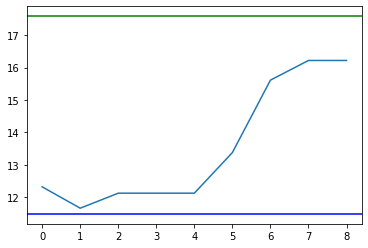


Policy Loss 2.7606143156687417
Value Loss 2.6497544050216675

Policy Loss 2.6981762647628784
Value Loss 1.8143092393875122
10/100
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 4, 15] 13.24544513333559
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 4, 15] 13.24544513333559
[3, 12, 6, 9, 14, 1, 7, 5, 15] 15.838160560454938
[3, 12, 6, 9, 14, 1, 7, 4, 15] 13.24544513333559


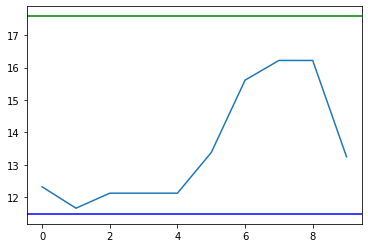


Policy Loss 2.6819045543670654
Value Loss 1.7650908331076305

Policy Loss 2.596392591794332
Value Loss 1.6577582309643428
11/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824
[3, 12, 6, 9, 14, 1, 4, 5, 15] 16.21798846815824


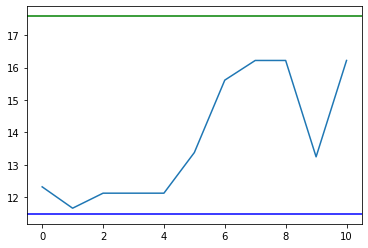


Policy Loss 2.5678433179855347
Value Loss 0.7710076247652372

Policy Loss 2.5552636981010437
Value Loss 0.5569726893057426
12/100
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 4, 15] 13.24544513333559
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267
[3, 12, 6, 9, 14, 1, 7, 8, 4] 12.948847716069267


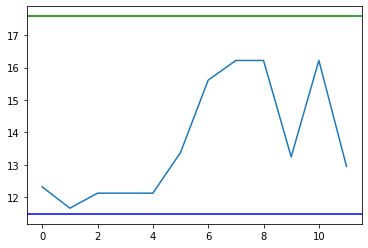


Policy Loss 2.701819817225138
Value Loss 3.8244830270608268

Policy Loss 2.6317803263664246
Value Loss 3.545378103852272
13/100
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788
[3, 12, 6, 9, 14, 1, 15, 5, 4] 15.962166698967788


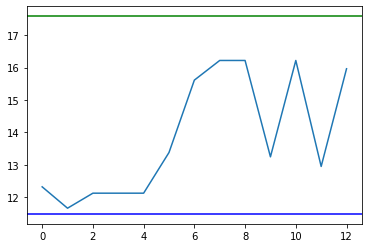


Policy Loss 2.606396516164144
Value Loss 2.6962675005197525

Policy Loss 2.539520482222239
Value Loss 1.8502815105021
14/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


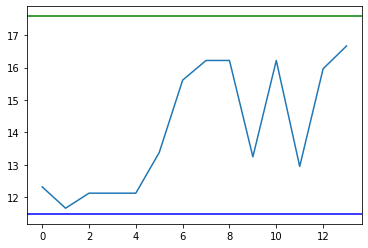


Policy Loss 2.5129809776941934
Value Loss 0.5872935485094786

Policy Loss 2.4197312792142234
Value Loss 0.34386412271608907
15/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


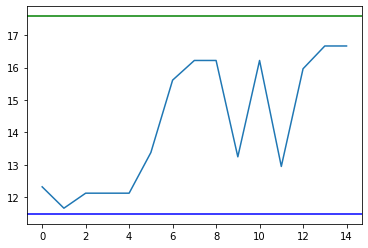


Policy Loss 2.379836599032084
Value Loss 0.4081929524739583

Policy Loss 2.327797055244446
Value Loss 0.2991645500684778
16/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


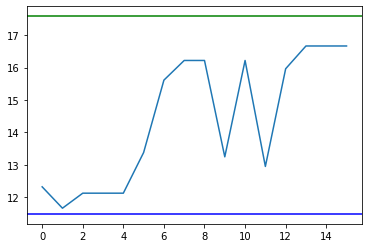


Policy Loss 2.3746238549550376
Value Loss 0.44543355765442055

Policy Loss 2.341137111186981
Value Loss 0.30377406037102145
17/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


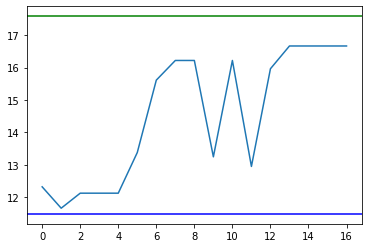


Policy Loss 2.211057265599569
Value Loss 0.13540453502597907

Policy Loss 2.150541047255198
Value Loss 0.10438062169123441
18/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


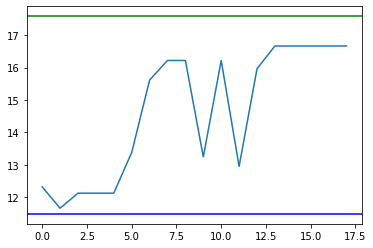


Policy Loss 2.2315552632013955
Value Loss 0.2708993597577016

Policy Loss 2.2268572449684143
Value Loss 0.18097255704924464
19/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


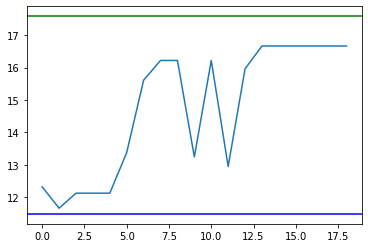


Policy Loss 2.131777902444204
Value Loss 0.3396226540207863

Policy Loss 2.109457125266393
Value Loss 0.2319082641042769
20/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


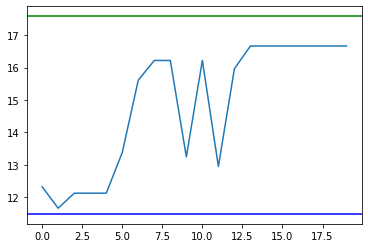


Policy Loss 1.989719072977702
Value Loss 0.24904030561447144

Policy Loss 2.0210726658503213
Value Loss 0.16686814123143753
21/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


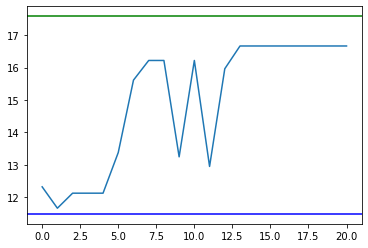


Policy Loss 2.016207138697306
Value Loss 0.32095789661010105

Policy Loss 2.0248268842697144
Value Loss 0.22816887684166431
22/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


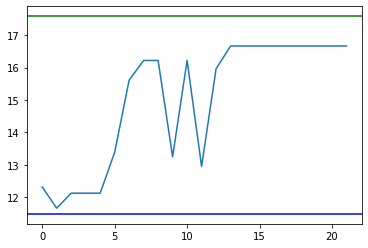


Policy Loss 2.0620323022206626
Value Loss 0.15522902032049993

Policy Loss 2.035492499669393
Value Loss 0.11829157922572146
23/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


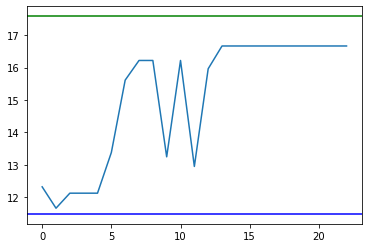


Policy Loss 1.9440749684969585
Value Loss 0.2018826132019361

Policy Loss 2.0041834910710654
Value Loss 0.15581548834840456
24/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


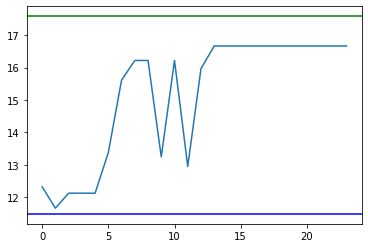


Policy Loss 1.8477190136909485
Value Loss 0.25352253019809723

Policy Loss 1.859609951575597
Value Loss 0.1617618945116798
25/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


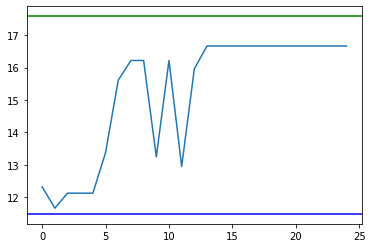


Policy Loss 1.8404576778411865
Value Loss 0.274131881693999

Policy Loss 1.842400809129079
Value Loss 0.17988881332955012
26/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


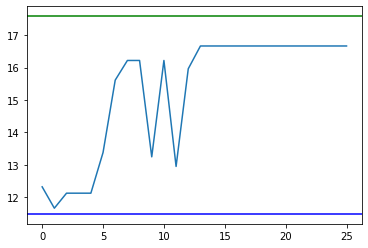


Policy Loss 1.7491029103597004
Value Loss 0.38795795540014905

Policy Loss 1.7714664936065674
Value Loss 0.2554834643378854
27/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


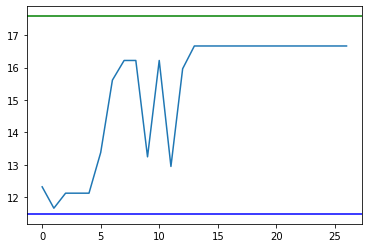


Policy Loss 1.5034554402033489
Value Loss 0.15463530582686266

Policy Loss 1.5681630373001099
Value Loss 0.10498042885834973
28/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


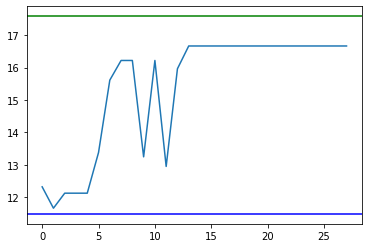


Policy Loss 1.641477346420288
Value Loss 0.2583255668481191

Policy Loss 1.6405070622762044
Value Loss 0.16753767477348447
29/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


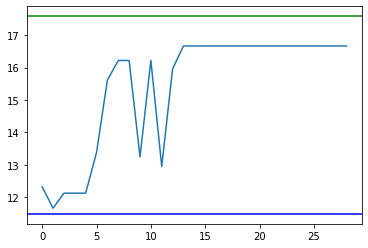


Policy Loss 1.5703237056732178
Value Loss 0.3583581658701102

Policy Loss 1.5931581556797028
Value Loss 0.24329801369458437
30/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


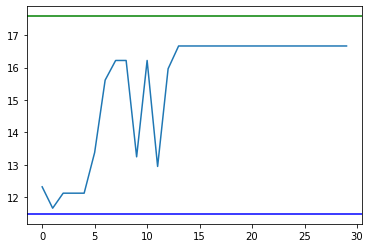


Policy Loss 1.6066160003344219
Value Loss 0.3272467215235035

Policy Loss 1.5819912056128185
Value Loss 0.2337072321679443
31/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


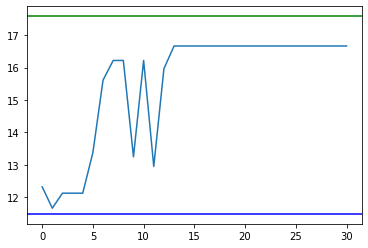


Policy Loss 1.5924085179964702
Value Loss 0.2605634269615014

Policy Loss 1.4951376517613728
Value Loss 0.1763782219204586
32/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


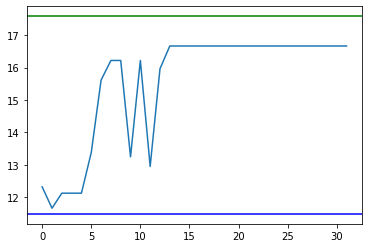


Policy Loss 1.4607834617296855
Value Loss 0.3101552575826645

Policy Loss 1.531523625055949
Value Loss 0.2126865559257567
33/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


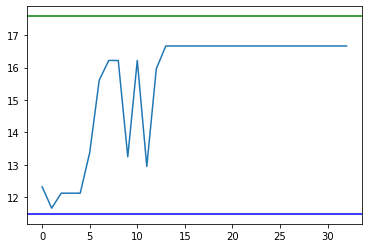


Policy Loss 1.6353610157966614
Value Loss 0.44242922961711884

Policy Loss 1.5235488613446553
Value Loss 0.3617648631334305
34/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


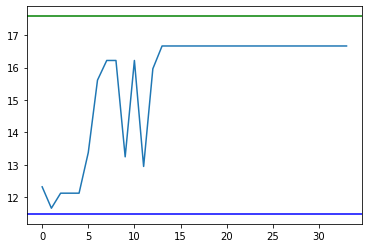


Policy Loss 1.5571345686912537
Value Loss 0.29666829357544583

Policy Loss 1.628965049982071
Value Loss 0.2028672806918621
35/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


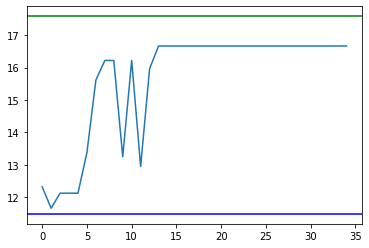


Policy Loss 1.5892694592475891
Value Loss 0.25237912436326343

Policy Loss 1.5865699648857117
Value Loss 0.15968602833648524
36/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


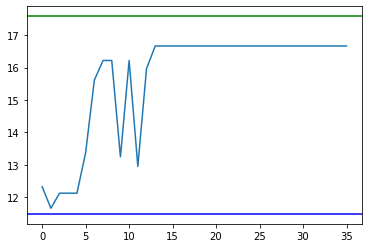


Policy Loss 1.4816986322402954
Value Loss 0.3135237321257591

Policy Loss 1.4136549830436707
Value Loss 0.23360442152867714
37/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


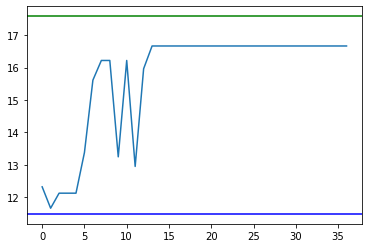


Policy Loss 1.4634541273117065
Value Loss 0.2607046247770389

Policy Loss 1.550365149974823
Value Loss 0.1715524517154942
38/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


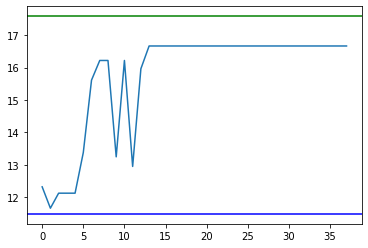


Policy Loss 1.4785887797673543
Value Loss 0.23843251168727875

Policy Loss 1.4368415772914886
Value Loss 0.1674695322290063
39/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


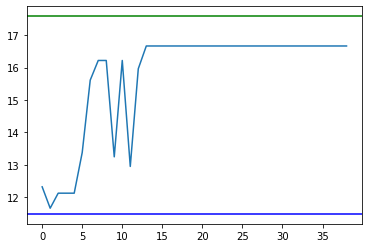


Policy Loss 1.3287957111994426
Value Loss 0.28103213012218475

Policy Loss 1.2559649248917897
Value Loss 0.18978880958942076
40/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


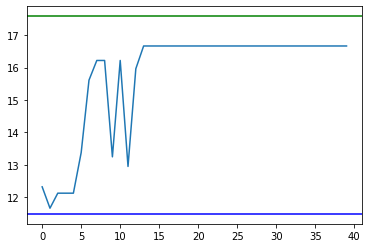


Policy Loss 1.4336425463358562
Value Loss 0.2962975266079108

Policy Loss 1.4654079675674438
Value Loss 0.19724110925259689
41/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


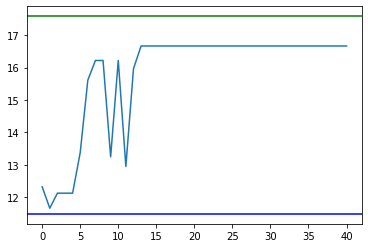


Policy Loss 1.3091778953870137
Value Loss 0.3376074687888225

Policy Loss 1.353431244691213
Value Loss 0.2282421893129746
42/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


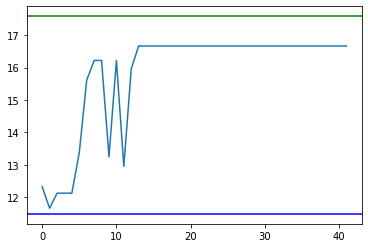


Policy Loss 1.418899377187093
Value Loss 0.31483996597429115

Policy Loss 1.387084384759267
Value Loss 0.21882527080985406
43/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


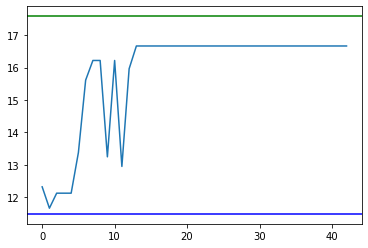


Policy Loss 1.2725421090920765
Value Loss 0.28559330975015956

Policy Loss 1.2642969836791356
Value Loss 0.21601689769886434
44/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


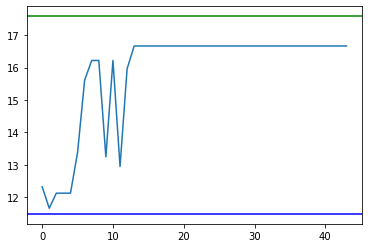


Policy Loss 1.1408334573109944
Value Loss 0.27596299101909

Policy Loss 1.1201148182153702
Value Loss 0.18140935696040592
45/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


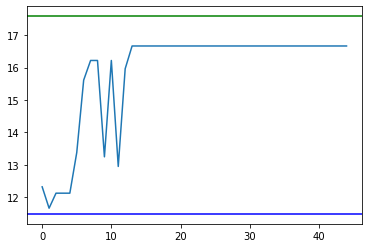


Policy Loss 1.2713632086912792
Value Loss 0.25591967192788917

Policy Loss 1.3109945406516392
Value Loss 0.1866952758282423
46/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


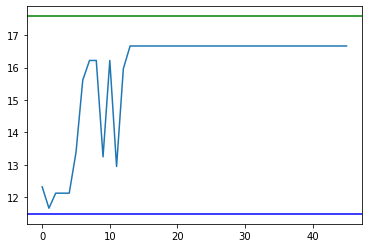


Policy Loss 1.2744806309541066
Value Loss 0.24852683767676353

Policy Loss 1.2508640786012013
Value Loss 0.15348492403669903
47/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


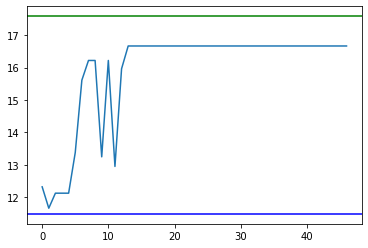


Policy Loss 1.049219290415446
Value Loss 0.31961729501684505

Policy Loss 1.1451821625232697
Value Loss 0.22628859849646688
48/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


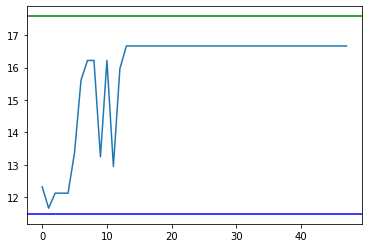


Policy Loss 0.9762850403785706
Value Loss 0.14986024944422147

Policy Loss 1.0071723908185959
Value Loss 0.11529642976044367
49/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


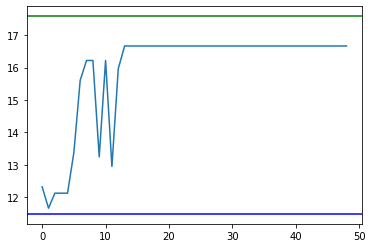


Policy Loss 1.1855787634849548
Value Loss 0.3404115210287273

Policy Loss 1.1453148325284321
Value Loss 0.23165698853942254
50/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


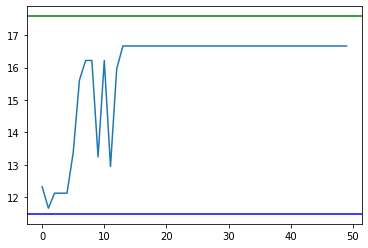


Policy Loss 1.0010023216406505
Value Loss 0.31756793272991973

Policy Loss 1.0702725996573765
Value Loss 0.2527861848163108
51/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


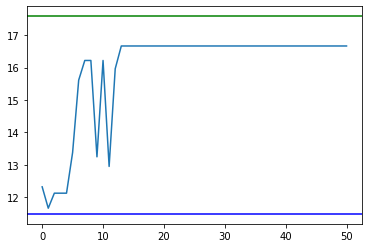


Policy Loss 0.9636515776316324
Value Loss 0.2474328875541687

Policy Loss 1.0479449232419331
Value Loss 0.16213841666467488
52/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


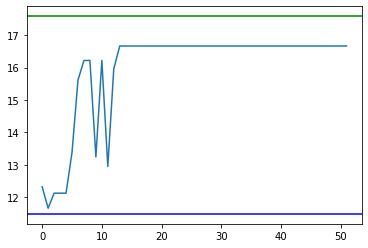


Policy Loss 1.2133280038833618
Value Loss 0.22122757012645403

Policy Loss 1.148855412999789
Value Loss 0.13918619385610023
53/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


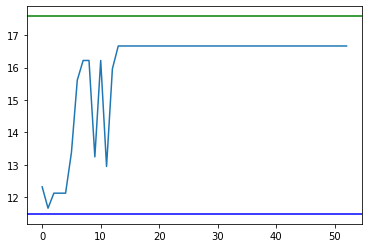


Policy Loss 1.078547219435374
Value Loss 0.250960111618042

Policy Loss 1.0332006613413494
Value Loss 0.1754623941378668
54/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


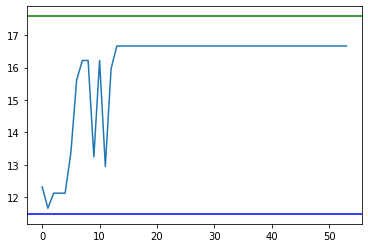


Policy Loss 0.9784281154473623
Value Loss 0.314262505620718

Policy Loss 0.9670266012350718
Value Loss 0.22545110092808804
55/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


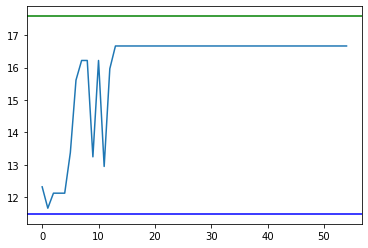


Policy Loss 1.0682713588078816
Value Loss 0.371359258890152

Policy Loss 0.9565057009458542
Value Loss 0.28436892681444687
56/100
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932
[3, 12, 6, 9, 14, 1, 15, 4, 7] 16.66482940827932


KeyboardInterrupt: 

In [16]:
import torch
import math
import pandas as pd
import numpy as np
import random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.spatial.distance as distlib
playlist_length = 10
model = MDP('MSD.csv', playlist_length)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'batch_size': 16,
    'numIters': 100,                                # Total number of training iterations
    'num_simulations': 200,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 10,                                  # Number of full games (episodes) to run during each iteration
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

dl_model = Connect2Model(model.n_features*model.playlist_length*10, model.n_songs, device)
print(model.n_songs)
trainer = Trainer(dl_model, model, args, [])

# Random
random_scores = [get_random_trajectory(model) for i in range(100)]
avg_random_score = sum(random_scores)/len(random_scores)

greedy_score = get_greedy_trajectory(model)
temp_array = [0.02, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]

for temp in temp_array:
    trainer.learn(temp, avg_random_score, greedy_score)



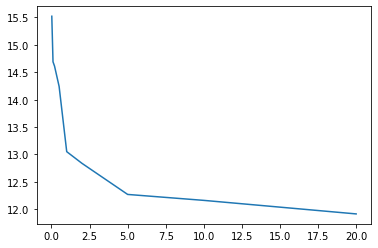

In [29]:
# ------------------------ PERFORMANCE EVALUATION------------------------
# 1) Evaluate the temperature effect on the performance of the DL MCTS
#-------------------------------------------------------------------------    

temp_array = [0.02, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20]
playlist_length = 10 # Playlist length that is used in evaluation
num_episodes = 100 # Number of episodes (i.e. playlists) that is used in evaluating the average score 
model = MDP('MSD.csv', playlist_length)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {                                            # args used in training to evaluate the temperature
    'batch_size': 16,
    'numIters': 100,                                # Total number of training iterations
    'num_simulations': 200,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 10,                                  # Number of full games (episodes) to run during each iteration
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

path = args['checkpoint_path']+'temperature: {}, numIters: {}, numEps: {}, numSims: {}'.format(0.02, args['numEps'], args['numIters'], args['num_simulations'])
dl_model = Connect2Model(model.n_features*model.playlist_length*10, model.n_songs, device)
avgRewards = np.array([])
j = 0
iter_duration_cumul = 0

for temp in temp_array:
    dl_model.load_state_dict(torch.load(path)['state_dict']) # load the weights of the checkpoint corresponding with the correct temperature
    trainerEval = Trainer(dl_model, model, args, [])
    cumRewardAcrossEpisodes = 0
    for i in range(num_episodes):
        time_start = time.time()
        cumRewardAcrossEpisodes += trainerEval.execute_episode(temp, False, _, _)[-1][2] # Select the reward out of the tuple of each episode

        iter_duration_cumul += time.time() - time_start
        iter_duration = iter_duration_cumul/((j+1)*(i) + i+1)
        time_remaining = iter_duration * (num_episodes * len(temp_array) - ((j+1)*(i) + i+1))

        print("Current rolling average: {:.2f}, maximum average: {:.2f}, episode: {}/{}, temperature: {}".format(cumRewardAcrossEpisodes/(i+1), 0 if (avgRewards.size == 0) else np.max(avgRewards), i+1, num_episodes, temp), end='\r')
    avgRewards = np.append(avgRewards, cumRewardAcrossEpisodes/num_episodes)
    j += 1

plt.plot(temp_array, avgRewards)
filename_timestr = time.strftime("%Y%m%d-%H%M%S-temperature_vs_rewards")

plt.plot(temperat)

In [33]:
out = dict(zip(temp_array, avgRewards))
if not os.path.exists('data'):
    os.mkdir('data')
file = open('./data/temp_vs_reward.pkl', 'wb')
pickle.dump(out, file)
file.close()

In [ ]:
args = {
    'batch_size': 16,
    'numIters': 10,                                # Total number of training iterations
    'num_simulations': 200,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 100,                                  # Number of full games (episodes) to run during each iteration
    'numItersForTrainExamplesHistory': 20,
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

for _ in range(200):
  # model = MDP('MSD.csv', playlist_length)

  # Random
  random_scores = [get_random_trajectory(model) for i in range(100)]
  avg_random_score = sum(random_scores)/len(randoms)
  
  greedy_score = get_greedy_trajectory(model)
  print("Random", cum_rewards, trajectory_actions)

kwargs = dict(alpha=0.5, bins=10)
print(randoms)
print(greedys)
print(MCTSs)
plt.hist(randoms, **kwargs, color='g', label='Random')
plt.hist(greedys, **kwargs, color='b', label='Greedy')
plt.hist(MCTSs, **kwargs, color='r', label='MCTS')
plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
# plt.xlim(50,75)
plt.legend()

NameError: name 'randoms' is not defined